In [ ]:
!pip install optuna xgboost scikit-learn pandas numpy joblib seaborn matplotlib scipy category_encoders imbalanced-learn lightgbm -q


In [ ]:
!pip install optuna

In [ ]:
!pip install xgboost

In [ ]:
!pip xgboost

ERROR: unknown command "xgboost"


In [ ]:
import xgboost as xgb
print(f"  XGBoost Version: {xgb.__version__}")
print(f"  Optuna Version: {optuna.__version__}")
print("✅ Step 0: 완료.")


  XGBoost Version: 3.0.0


NameError: name 'optuna' is not defined

In [ ]:
# --- Google Drive 마운트 (Colab 환경 필수) ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("✅ Google Drive 마운트 완료.")
except ModuleNotFoundError:
    print("⚠️ Google Colab 환경이 아니거나 drive 모듈을 찾을 수 없습니다. 로컬 경로를 사용하세요.")
# ---------------------------------------------



Mounted at /content/drive
✅ Google Drive 마운트 완료.


NameError: name 'xgb' is not defined

In [ ]:

import os
import gc
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

# ✅ 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

# ✅ 경로 설정
base_path = "/content/drive/MyDrive/Colab Notebooks/open/"
temp_path = "/content/drive/MyDrive/Colab Notebooks/temp_chunks"
os.makedirs(temp_path, exist_ok=True)
os.makedirs("/content/drive/MyDrive/model", exist_ok=True)

# ✅ 데이터 분할
splits = ["train", "test"]
months = ['07', '08', '09', '10', '11', '12']

# ✅ 데이터 카테고리 정의
category_info = {
    "customer": ("1.회원정보", "회원정보"),
    "credit": ("2.신용정보", "신용정보"),
    "sales": ("3.승인매출정보", "승인매출정보"),
    "billing": ("4.청구입금정보", "청구정보"),
    "balance": ("5.잔액정보", "잔액정보"),
    "channel": ("6.채널정보", "채널정보"),
    "marketing": ("7.마케팅정보", "마케팅정보"),
    "performance": ("8.성과정보", "성과정보")
}

# ✅ 데이터 병합 및 저장
for split in splits:
    print(f"\n### {split.upper()} 데이터 처리 ###")
    for key, (folder, suffix) in category_info.items():
        combined_df = []
        for month in months:
            file_path = f"{base_path}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            try:
                df = pd.read_parquet(file_path)
                combined_df.append(df)
                print(f"  ✅ {file_path} 로드 완료")
            except Exception as e:
                print(f"  ⚠️ {file_path} 로드 실패: {e}")
        if combined_df:
            df_all = pd.concat(combined_df, axis=0)
            df_all.to_parquet(f"{temp_path}/{key}_{split}_combined.parquet", index=False)
            print(f"  ✅ 저장 완료: {key}_{split}_combined.parquet")
            del df_all
            gc.collect()

# ✅ 순차 병합 함수 정의
def sequential_merge(split):
    print(f"\n### {split.upper()} 데이터 병합 ###")
    base_df = pd.read_parquet(f"{temp_path}/customer_{split}_combined.parquet")
    for key in list(category_info.keys())[1:]:
        df = pd.read_parquet(f"{temp_path}/{key}_{split}_combined.parquet")
        base_df = base_df.merge(df, on=['기준년월', 'ID'], how='left')
        print(f"  ✅ 병합 완료: {key}")
        del df
        gc.collect()
    base_df.to_parquet(f"{temp_path}/{split}_final.parquet", index=False)
    print(f"✅ {split} 최종 저장 완료: {split}_final.parquet")
    return base_df

train_df = sequential_merge("train")
test_df = sequential_merge("test")


# 일반모델

In [ ]:

import os
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 모델/객체 저장용
import optuna # 하이퍼파라미터 튜닝

# 전처리 및 피처 엔지니어링
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from scipy.stats.mstats import winsorize
import category_encoders as ce
import lightgbm as lgb # 피처 선택용 임시 모델

# 클래스 불균형 처리
from imblearn.over_sampling import SMOTE

# 모델 학습 및 평가
from sklearn.model_selection import StratifiedKFold, train_test_split # train_test_split 추가
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# 기타
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import optuna
import os
import pandas as pd # best_params 출력 위해 임포트

# --- 설정 (이전 코드와 동일하게 맞춰야 함) ---
# *** MODEL_SAVE_PATH 변수가 정의되어 있고, 올바른 경로를 가리키는지 확인! ***
MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/temp_chunks" # 예시 경로, 실제 경로로 수정!
study_name = 'xgboost-hyperopt-macrof1-sampled-v2' # 확인할 스터디 이름
# -------------------------------------------

db_filename = f"{study_name}.db"
storage_path = os.path.join(MODEL_SAVE_PATH, db_filename)
storage_name = f"sqlite:///{storage_path}"

print(f"확인하려는 Optuna 스터디 DB 경로: {storage_name}")

try:
    # 기존 스터디 로드 시도
    study = optuna.load_study(study_name=study_name, storage=storage_name)

    print(f"\n--- 스터디 '{study_name}' 진행 상황 ---")

    # 완료된 Trial 수 확인
    completed_trials = len(study.trials)
    print(f"완료된 Trial 수: {completed_trials}")

    # 목표 Trial 수 (이전에 설정했던 값)
    total_trials_planned = 100 # 예시 (실제 설정했던 값으로 변경 가능)
    print(f"목표 Trial 수: {total_trials_planned}")
    if completed_trials < total_trials_planned:
        print(f"남은 Trial 수: {total_trials_planned - completed_trials}")
    else:
        print("모든 Trial이 완료되었습니다.")

    # 현재까지 찾은 Best Trial 정보 출력
    if completed_trials > 0:
        print(f"\n현재까지 Best Trial:")
        best_trial = study.best_trial
        print(f"  - Trial 번호: {best_trial.number}")
        print(f"  - Value (OOF Macro F1 on Sampled): {best_trial.value:.6f}")
        print(f"  - Best Params:")
        # 파라미터를 보기 좋게 출력
        best_params_df = pd.DataFrame([best_trial.params])
        print(best_params_df.T) # Transpose 로 보기 좋게 출력
    else:
        print("\n아직 완료된 Trial이 없습니다.")

except FileNotFoundError:
     print(f"❌ 오류: 경로 '{storage_path}' 에서 DB 파일을 찾을 수 없습니다.")
     print("   => MODEL_SAVE_PATH 변수와 study_name을 확인하세요.")
except KeyError:
     print(f"❌ 오류: DB 파일 '{db_filename}' 에서 스터디 이름 '{study_name}'을(를) 찾을 수 없습니다.")
     print("   => study_name이 정확한지 확인하세요.")
except Exception as e:
    print(f"❌ 스터디 로드 중 오류 발생: {e}")

확인하려는 Optuna 스터디 DB 경로: sqlite:////content/drive/MyDrive/Colab Notebooks/temp_chunks/xgboost-hyperopt-macrof1-sampled-v2.db

--- 스터디 'xgboost-hyperopt-macrof1-sampled-v2' 진행 상황 ---
완료된 Trial 수: 105
목표 Trial 수: 100
모든 Trial이 완료되었습니다.

현재까지 Best Trial:
  - Trial 번호: 14
  - Value (OOF Macro F1 on Sampled): 0.743042
  - Best Params:
                         0
eta               0.095891
max_depth         6.000000
subsample         0.874640
colsample_bytree  0.506655
min_child_weight  4.000000
gamma             3.806457
lambda            2.183626
alpha             3.886105


In [ ]:

# ==============================================================================
# ✅ Step 1: 설정 및 데이터 로드
# ------------------------------------------------------------------------------
print("\n🔄 Step 1: 설정 및 데이터 로드...")

# --- 경로 설정 (***가장 중요: 본인 환경에 맞게 정확히 수정***) ---
DRIVE_BASE_PATH = "/content/drive/MyDrive"
# *** 아래 TEMP_PATH 를 본인의 실제 Parquet 파일이 있는 폴더 경로로 수정하세요! ***
TEMP_PATH = os.path.join(DRIVE_BASE_PATH, "Colab Notebooks/temp_chunks") # 예시 경로
MODEL_SAVE_PATH = os.path.join(DRIVE_BASE_PATH, "model_tuned_final_sampled") # 결과 저장 경로 변경
os.makedirs(TEMP_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

if not os.path.exists(TEMP_PATH): print(f"⚠️ 경고: 데이터 경로 '{TEMP_PATH}' 를 찾을 수 없습니다.")
else: print(f"  데이터 경로 확인: {TEMP_PATH}")
print(f"  모델 저장 경로: {MODEL_SAVE_PATH}")
# ---------------------------------------------------------------

# --- 주요 설정 ---
TARGET_COLUMN = "Segment"
ID_COLUMN = "ID"
N_SPLITS = 5 # <<< 최종 K-Fold 분할 수
RANDOM_STATE = 42
epsilon = 1e-6
# -----------------

# 데이터 로드
train_file = os.path.join(TEMP_PATH, "train_final.parquet")
test_file = os.path.join(TEMP_PATH, "test_final.parquet")
try:
    print(f"  '{train_file}' 로딩 시도...")
    train_df = pd.read_parquet(train_file)
    print(f"✅ Train 데이터 로딩 완료: {train_df.shape}")

    print(f"  '{test_file}' 로딩 시도...")
    test_df = pd.read_parquet(test_file)
    print(f"✅ Test 데이터 로딩 완료: {test_df.shape}")
    if ID_COLUMN in test_df.columns: print(f"   로드된 Test 데이터 고유 ID 수: {test_df[ID_COLUMN].nunique()}")
    else: print(f"   경고: '{ID_COLUMN}' 컬럼 없음.")

except FileNotFoundError as e:
    print(f"❌ 치명적 오류: 데이터 파일 '{e.filename}'을(를) 찾을 수 없습니다.")
    print(f"   => 경로 및 파일명을 확인하고 Google Drive 마운트 여부를 확인하세요.")
    raise e
print("✅ Step 1: 완료.")


# ==============================================================================
# ✅ Step 2: 기본 전처리 (결측치, 이상치, 타겟 인코딩)
# ------------------------------------------------------------------------------
print("\n🔄 Step 2: 기본 전처리...")
start_time_step2 = time.time()

y = train_df[TARGET_COLUMN].copy()
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
num_classes = len(le_target.classes_)
print(f"  타겟 변수 인코딩 완료. 클래스 개수: {num_classes}")

X = train_df.drop(columns=[ID_COLUMN, TARGET_COLUMN])
X_test = test_df.drop(columns=[ID_COLUMN])
test_ids = test_df[ID_COLUMN] # <<< 테스트 ID 저장
del train_df, test_df, y; gc.collect()

numerical_features_initial = X.select_dtypes(include=np.number).columns.tolist()
categorical_features_initial = X.select_dtypes(exclude=np.number).columns.tolist()
print(f"  초기 피처 수: {X.shape[1]} (수치형: {len(numerical_features_initial)}, 범주형: {len(categorical_features_initial)})")

print("  결측치 처리 중...")
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
X[numerical_features_initial] = num_imputer.fit_transform(X[numerical_features_initial])
X[categorical_features_initial] = cat_imputer.fit_transform(X[categorical_features_initial])
X_test[numerical_features_initial] = num_imputer.transform(X_test[numerical_features_initial])
X_test[categorical_features_initial] = cat_imputer.transform(X_test[categorical_features_initial])
print("  결측치 처리 완료.")

print("  이상치 처리 (Winsorization) 중...")
winsorize_alpha = 0.01
for col in numerical_features_initial:
    X[col] = winsorize(X[col], limits=(winsorize_alpha, winsorize_alpha))
    q_low, q_high = np.percentile(X[col], [winsorize_alpha * 100, (1 - winsorize_alpha) * 100])
    X_test[col] = np.clip(X_test[col], q_low, q_high)
print("  이상치 처리 완료.")

end_time_step2 = time.time()
print(f"✅ Step 2 완료. (소요 시간: {end_time_step2 - start_time_step2:.2f} 초)")


# ==============================================================================
# ✅ Step 3: 통합 피처 엔지니어링 함수 정의
# ------------------------------------------------------------------------------
print("\n🔄 Step 3: 통합 피처 엔지니어링 함수 정의...")

def apply_feature_engineering(df, numerical_features, categorical_features, fit_objects=None):
    """ 기본 및 고급 피처 엔지니어링 통합 적용 함수 (수정된 최종본) """
    X_eng = df.copy()
    current_num_features = numerical_features[:]
    current_cat_features = categorical_features[:]
    is_training = (fit_objects is None)
    if is_training: fit_objects = {}
    # print("  피처 엔지니어링 시작...") # 상세 로그 필요시 주석 해제
    epsilon = 1e-6

    # --- 0. 분산 0 피처 제거 ---
    if is_training:
        temp_df_for_vt = X_eng[current_num_features].copy()
        temp_df_for_vt = np.nan_to_num(temp_df_for_vt, nan=0.0, posinf=0.0, neginf=0.0)
        vt = VarianceThreshold(threshold=0.0)
        try:
            vt.fit(temp_df_for_vt)
            fit_objects['variance_threshold'] = vt
            cols_to_keep_mask = vt.get_support()
            cols_to_keep = X_eng[current_num_features].columns[cols_to_keep_mask].tolist()
            cols_dropped = len(current_num_features) - len(cols_to_keep)
            print(f"    (0) 분산 0 피처 제거: {cols_dropped}개 제거됨.")
            current_num_features = cols_to_keep
        except Exception as e: print(f"    (0) 분산 0 피처 제거 중 오류: {e}.")
    else:
        if 'variance_threshold' in fit_objects:
            vt = fit_objects['variance_threshold']
            cols_to_keep = df[numerical_features].columns[vt.get_support()].tolist()
            current_num_features = cols_to_keep
        # else: print("    (0) 경고: 분산 임계값 객체 없음.")

    # --- 1. 로그 변환 ---
    log_cols = [col for col in current_num_features if '금액' in col or '원금' in col or '평잔' in col]
    added_log_features = []
    for col in log_cols:
        col_log = f'{col}_log1p'
        if col in X_eng.columns and pd.api.types.is_numeric_dtype(X_eng[col]):
            min_val = X_eng[col].min(); X_eng[col_log] = np.log1p(X_eng[col] - min_val) if min_val <= 0 else np.log1p(X_eng[col])
            added_log_features.append(col_log)
    current_num_features.extend(list(set(added_log_features)))
    # print(f"    (1) 로그 변환 피처 {len(added_log_features)}개 추가 완료.")

    # --- 2. 총합 및 기본 비율 ---
    amount_cols_r12m = [col for col in current_num_features if '이용금액' in col and 'R12M' in col and '최대' not in col and '_log1p' not in col and col in X_eng.columns]
    count_cols_r12m = [col for col in current_num_features if '이용건수' in col and 'R12M' in col and '_log1p' not in col and col in X_eng.columns]
    created_agg_features = []
    if amount_cols_r12m: X_eng['총이용금액_R12M'] = X_eng[amount_cols_r12m].sum(axis=1); created_agg_features.append('총이용금액_R12M')
    if count_cols_r12m: X_eng['총이용건수_R12M'] = X_eng[count_cols_r12m].sum(axis=1); created_agg_features.append('총이용건수_R12M')
    if '총이용금액_R12M' in X_eng.columns and '총이용건수_R12M' in X_eng.columns:
        total_amount = pd.to_numeric(X_eng['총이용금액_R12M'], errors='coerce').fillna(0)
        total_count = pd.to_numeric(X_eng['총이용건수_R12M'], errors='coerce').fillna(0)
        X_eng['평균거래금액_R12M'] = total_amount / (total_count + epsilon); created_agg_features.append('평균거래금액_R12M')
    current_num_features.extend(list(set(created_agg_features)))
    # print(f"    (2) 총합/평균 관련 피처 {len(created_agg_features)}개 생성.")

    # --- 3. 소비 패턴 ---
    created_pattern_features = []
    online_spending_col = '쇼핑_온라인_이용금액' # 실제 컬럼명 확인 필요
    if online_spending_col in X_eng.columns and '총이용금액_R12M' in X_eng.columns:
        online_amount = pd.to_numeric(X_eng[online_spending_col], errors='coerce').fillna(0)
        total_amount = pd.to_numeric(X_eng['총이용금액_R12M'], errors='coerce').fillna(0)
        X_eng['온라인소비비중_R12M'] = online_amount / (total_amount + epsilon); created_pattern_features.append('온라인소비비중_R12M')
    amount_r3m_col = '이용금액_R3M_신용체크' # 실제 컬럼명 확인 필요
    amount_r12m_col_proxy = '총이용금액_R12M' # 실제 컬럼명 확인 필요
    if amount_r3m_col in X_eng.columns and amount_r12m_col_proxy in X_eng.columns:
        amount_r3m = pd.to_numeric(X_eng[amount_r3m_col], errors='coerce').fillna(0)
        amount_r12m = pd.to_numeric(X_eng[amount_r12m_col_proxy], errors='coerce').fillna(0)
        X_eng['최근소비집중도'] = (amount_r3m * 4) / (amount_r12m + epsilon); created_pattern_features.append('최근소비집중도')
    current_num_features.extend(list(set(created_pattern_features)))
    # print(f"    (3) 소비 패턴 관련 피처 {len(created_pattern_features)}개 생성.")

    # --- 4. 신용도 및 위험 관리 ---
    created_risk_features = []
    limit_col = '카드이용한도금액'; billing_col = '청구금액_B0' # 실제 컬럼명 확인 필요
    if limit_col in X_eng.columns and billing_col in X_eng.columns:
        limit = pd.to_numeric(X_eng[limit_col], errors='coerce').fillna(0); billing = pd.to_numeric(X_eng[billing_col], errors='coerce').fillna(0)
        X_eng['한도소진율_청구기준'] = billing / (limit + epsilon); X_eng['한도소진율_청구기준'] = X_eng['한도소진율_청구기준'].clip(0, 1.5)
        created_risk_features.append('한도소진율_청구기준')
    delinquency_cols = [col for col in current_num_features if '연체' in col and ('이용금액' in col or '원금' in col) and '_log1p' not in col and col in X_eng.columns]
    added_delinq_feature = False
    if delinquency_cols:
        delinquency_sum = X_eng[delinquency_cols].apply(pd.to_numeric, errors='coerce').fillna(0).sum(axis=1)
        X_eng['연체경험유무'] = (delinquency_sum > 0).astype(int)
        if '연체경험유무' not in current_cat_features: current_cat_features.append('연체경험유무'); added_delinq_feature = True
    current_num_features.extend(list(set(created_risk_features)))
    # print(f"    (4) 신용도/위험 관련 피처 {len(created_risk_features) + (1 if added_delinq_feature else 0)}개 생성.")

    # --- 5. 채널 활용 패턴 ---
    created_channel_features = []
    app_visits_col = '방문횟수_앱_R6M'; pc_visits_col = '방문횟수_PC_R6M'; ars_calls_col = '인입횟수_ARS_R6M' # 실제 컬럼명 확인 필요
    if app_visits_col in X_eng.columns and pc_visits_col in X_eng.columns and ars_calls_col in X_eng.columns:
        app_visits = pd.to_numeric(X_eng[app_visits_col], errors='coerce').fillna(0); pc_visits = pd.to_numeric(X_eng[pc_visits_col], errors='coerce').fillna(0); ars_calls = pd.to_numeric(X_eng[ars_calls_col], errors='coerce').fillna(0)
        total_contacts = app_visits + pc_visits + ars_calls
        X_eng['디지털채널선호도'] = (app_visits + pc_visits) / (total_contacts + epsilon); created_channel_features.append('디지털채널선호도')
    current_num_features.extend(list(set(created_channel_features)))
    # print(f"    (5) 채널 활용 관련 피처 {len(created_channel_features)}개 생성.")

    # --- 6. 기본 FE 통합 (비율, 이산화, 클러스터링) ---
    created_basic_num_features = []; created_basic_cat_features = []
    col1_r = '이용금액_R3M_신용체크'; col2_r = '이용개월수_신용_R12M' # 실제 컬럼명 확인 필요
    if col1_r in X_eng.columns and col2_r in X_eng.columns:
        val1 = pd.to_numeric(X_eng[col1_r], errors='coerce').fillna(0); val2 = pd.to_numeric(X_eng[col2_r], errors='coerce').fillna(0)
        X_eng['ratio_신용금액_per_개월'] = val1 / (val2 + epsilon); created_basic_num_features.append('ratio_신용금액_per_개월')
    bin_col = '연속유실적개월수_기본_24M_카드' # 실제 컬럼명 확인 필요
    if bin_col in X_eng.columns:
        bin_input = pd.to_numeric(X_eng[bin_col], errors='coerce'); bins = [-np.inf, 3, 6, 12, np.inf]; labels = [0, 1, 2, 3]
        X_eng[f'{bin_col}_bin'] = pd.cut(bin_input.fillna(-1), bins=bins, labels=labels, right=True).astype('category'); created_basic_cat_features.append(f'{bin_col}_bin')
    cluster_cols_log = [col for col in current_num_features if '_log1p' in col and col in X_eng.columns]
    if len(cluster_cols_log) >= 2:
        cluster_input = X_eng[cluster_cols_log].copy(); cluster_input = np.nan_to_num(cluster_input, nan=0.0, posinf=0.0, neginf=0.0)
        if is_training:
            qt = QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE)
            kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init=10)
            cluster_input_scaled = qt.fit_transform(cluster_input); X_eng['cluster_feature'] = kmeans.fit_predict(cluster_input_scaled)
            fit_objects['kmeans'] = kmeans; fit_objects['qt_cluster'] = qt
        else:
            if 'kmeans' in fit_objects and 'qt_cluster' in fit_objects:
                qt = fit_objects['qt_cluster']; kmeans = fit_objects['kmeans']
                cluster_input_scaled = qt.transform(cluster_input); X_eng['cluster_feature'] = kmeans.predict(cluster_input_scaled)
            else: X_eng['cluster_feature'] = -1
        created_basic_cat_features.append('cluster_feature'); del cluster_input, cluster_input_scaled; gc.collect()
    current_num_features.extend(list(set(created_basic_num_features)))
    current_cat_features.extend(list(set(created_basic_cat_features)))
    # print(f"    (6) 기존 FE (비율, 이산화, 클러스터링) 통합 적용.")

    # --- 7. 최종 정리 및 안정성 확인 ---
    final_num_features = sorted(list(set([f for f in current_num_features if f in X_eng.columns])))
    final_cat_features = sorted(list(set([f for f in current_cat_features if f in X_eng.columns])))
    final_cat_features = [f for f in final_cat_features if f not in final_num_features]
    final_columns = final_num_features + final_cat_features
    X_eng = X_eng[final_columns].copy()

    if X_eng.isnull().any().any() or (len(final_num_features)>0 and np.isinf(X_eng[final_num_features].values).any().any()):
         print("    최종 안정성 확인: NaN/Inf 발견. 대체 처리.")
         for col in final_num_features:
            X_eng[col] = pd.to_numeric(X_eng[col], errors='coerce')
            X_eng[col] = np.nan_to_num(X_eng[col].fillna(0), nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
         for col in final_cat_features:
             if X_eng[col].isnull().any():
                 mode_val = X_eng[col].mode()[0] if not X_eng[col].mode().empty else '__MISSING__'
                 X_eng[col] = X_eng[col].fillna(mode_val).astype(str)
                 try: X_eng[col] = X_eng[col].astype('category')
                 except: pass

    # print(f"  피처 엔지니어링 완료. 최종 피처 수: {X_eng.shape[1]}")
    return X_eng, final_num_features, final_cat_features, fit_objects

print("✅ Step 3: 함수 정의 완료.")


# ==============================================================================
# ✅ Step 4: 피처 엔지니어링 실행
# ------------------------------------------------------------------------------
print("\n🔄 Step 4: 피처 엔지니어링 실행...")
start_time_step4 = time.time()
try:
    X_engineered, numerical_features_eng, categorical_features_eng, fit_objects_fe = apply_feature_engineering(
        X, numerical_features_initial, categorical_features_initial, fit_objects=None
    )
    X_test_engineered, _, _, _ = apply_feature_engineering(
        X_test, numerical_features_initial, categorical_features_initial, fit_objects=fit_objects_fe
    )
    print(f"  최종 수치형 피처 수 (FE 후): {len(numerical_features_eng)}")
    print(f"  최종 범주형 피처 수 (FE 후): {len(categorical_features_eng)}")
    del X, X_test; gc.collect()
    end_time_step4 = time.time()
    print(f"✅ Step 4 완료. (소요 시간: {end_time_step4 - start_time_step4:.2f} 초)")
except Exception as e:
    print(f"❌ Step 4 실행 중 오류 발생: {e}"); import traceback; traceback.print_exc(); exit()




🔄 Step 1: 설정 및 데이터 로드...
  데이터 경로 확인: /content/drive/MyDrive/Colab Notebooks/temp_chunks
  모델 저장 경로: /content/drive/MyDrive/model_tuned_final_sampled
  '/content/drive/MyDrive/Colab Notebooks/temp_chunks/train_final.parquet' 로딩 시도...
✅ Train 데이터 로딩 완료: (2400000, 858)
  '/content/drive/MyDrive/Colab Notebooks/temp_chunks/test_final.parquet' 로딩 시도...
✅ Test 데이터 로딩 완료: (600000, 857)
   로드된 Test 데이터 고유 ID 수: 100000
✅ Step 1: 완료.

🔄 Step 2: 기본 전처리...
  타겟 변수 인코딩 완료. 클래스 개수: 5
  초기 피처 수: 856 (수치형: 808, 범주형: 48)
  결측치 처리 중...
  결측치 처리 완료.
  이상치 처리 (Winsorization) 중...
  이상치 처리 완료.
✅ Step 2 완료. (소요 시간: 492.95 초)

🔄 Step 3: 통합 피처 엔지니어링 함수 정의...
✅ Step 3: 함수 정의 완료.

🔄 Step 4: 피처 엔지니어링 실행...
    (0) 분산 0 피처 제거: 226개 제거됨.
    최종 안정성 확인: NaN/Inf 발견. 대체 처리.
    최종 안정성 확인: NaN/Inf 발견. 대체 처리.
  최종 수치형 피처 수 (FE 후): 798
  최종 범주형 피처 수 (FE 후): 51
✅ Step 4 완료. (소요 시간: 335.58 초)


In [ ]:

# ==============================================================================
# ✅ Step 5: 피처 선택 (SelectFromModel 사용)
# ------------------------------------------------------------------------------
print("\n🔄 Step 5: 피처 선택...")
start_time_step5 = time.time()
try:
    X_temp_fs = X_engineered.copy()
    cat_features_for_fs = X_engineered.select_dtypes(include=['object', 'category']).columns.tolist()
    encoders_fs = {}
    for col in cat_features_for_fs:
        le_fs = LabelEncoder(); X_temp_fs[col] = le_fs.fit_transform(X_temp_fs[col].astype(str)); encoders_fs[col] = le_fs
    print(f"  피처 선택용 임시 인코딩 완료 ({len(cat_features_for_fs)}개).")

    print("  피처 선택용 임시 LightGBM 모델 학습...")
    lgbm_selector = lgb.LGBMClassifier(random_state=RANDOM_STATE, objective='multiclass', metric='multi_logloss', n_jobs=-1)
    lgbm_selector.fit(X_temp_fs, y_encoded)

    selector = SelectFromModel(lgbm_selector, threshold='median', prefit=True)
    selected_feature_names = X_temp_fs.columns[selector.get_support()].tolist()
    print(f"  SelectFromModel 적용 완료. 선택된 피처 수: {len(selected_feature_names)}")

    X_final = X_engineered[selected_feature_names].copy()
    X_test_final = X_test_engineered[selected_feature_names].copy()

    numerical_features_selected = X_final.select_dtypes(include=np.number).columns.tolist()
    categorical_features_selected = X_final.select_dtypes(exclude=np.number).columns.tolist()
    feature_names_final = selected_feature_names
    print(f"  최종 선택된 피처: 수치형 {len(numerical_features_selected)}개, 범주형 {len(categorical_features_selected)}개")

    del X_engineered, X_test_engineered, X_temp_fs, lgbm_selector, selector, encoders_fs; gc.collect()
    end_time_step5 = time.time()
    print(f"✅ Step 5 완료. (소요 시간: {end_time_step5 - start_time_step5:.2f} 초)")
except Exception as e:
    print(f"❌ Step 5 실행 중 오류 발생: {e}"); import traceback; traceback.print_exc(); exit()


# ==============================================================================
# ✅ Step 6: Optuna Objective 함수 정의 (데이터 서브샘플링 + 축소 K-Fold 적용)
# ------------------------------------------------------------------------------
print("\n🔄 Step 6: Optuna Objective 함수 정의...")

# Optuna Objective 함수 정의 (데이터 서브샘플링 + 축소 K-Fold 적용)
def objective(trial):
    SAMPLE_FRAC = 0.2 # 튜닝 시 사용할 데이터 비율
    N_FOLDS_TUNING = 3 # 튜닝 시 사용할 Fold 수
    # print(f"\n--- Trial {trial.number} ---")

    try:
        if 'X_final' not in globals() or 'y_encoded' not in globals(): raise NameError("X_final/y_encoded 없음")
        _, X_sample, _, y_sample = train_test_split(
            X_final, y_encoded, test_size=SAMPLE_FRAC,
            random_state=RANDOM_STATE + trial.number, stratify=y_encoded )
    except Exception as e: print(f"Subsampling Error: {e}"); return 0.0
    gc.collect()

    params = { # 하이퍼파라미터 탐색 공간
        'objective': 'multi:softprob', 'num_class': num_classes, 'eval_metric': 'mlogloss',
        'eta': trial.suggest_float('eta', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'lambda': trial.suggest_float('lambda', 0.1, 100.0, log=True),
        'alpha': trial.suggest_float('alpha', 0.0, 10.0),
        'tree_method': 'hist', 'device': 'cuda' if xgb.config.get_config().get('USE_CUDA', False) else 'cpu',
        'random_state': RANDOM_STATE, 'nthread': -1
    }
    num_boost_round = 1000 # 튜닝 시 라운드 수
    early_stopping_rounds = 75 # 튜닝 시 조기 종료 라운드

    oof_preds_proba = np.zeros((len(X_sample), num_classes)); oof_labels = np.zeros(len(X_sample))
    kf = StratifiedKFold(n_splits=N_FOLDS_TUNING, shuffle=True, random_state=RANDOM_STATE)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_sample, y_sample)):
        X_train_fold, X_val_fold = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
        y_train_fold, y_val_fold = y_sample[train_idx], y_sample[val_idx]

        # Target Encoding
        target_encoder_fold = None
        if categorical_features_selected: # Step 5에서 정의된 리스트 사용
             try:
                 target_encoder_fold = ce.TargetEncoder(cols=categorical_features_selected, handle_missing='value', handle_unknown='value', smoothing=1.0)
                 X_train_fold = target_encoder_fold.fit_transform(X_train_fold, y_train_fold)
                 X_val_fold = target_encoder_fold.transform(X_val_fold)
             except Exception as e_te: print(f"TE Error: {e_te}") # 오류 시 일단 진행

        # SMOTE
        smote = SMOTE(random_state=RANDOM_STATE + fold + trial.number, k_neighbors=5)
        try: X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
        except Exception: X_train_resampled, y_train_resampled = X_train_fold, y_train_fold # 원본 사용

        # DMatrix 생성
        X_train_resampled = np.nan_to_num(X_train_resampled.astype(np.float32), nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
        X_val_fold = np.nan_to_num(X_val_fold.astype(np.float32), nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
        try:
            dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled, feature_names=feature_names_final) # Step 5에서 정의
            dval = xgb.DMatrix(X_val_fold, label=y_val_fold, feature_names=feature_names_final)
        except Exception as e_dm: print(f"DMatrix Error: {e_dm}"); return 0.0 # 오류 시 낮은 점수 반환

        # XGBoost 학습
        try:
            # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "eval-mlogloss") # 필요시 Pruning 추가
            booster = xgb.train(
                params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                evals=[(dval, 'eval')], early_stopping_rounds=early_stopping_rounds,
                verbose_eval=False # callbacks=[pruning_callback]
            )
            val_preds_proba = booster.predict(dval, iteration_range=(0, booster.best_iteration))
            oof_preds_proba[val_idx] = val_preds_proba
            oof_labels[val_idx] = y_val_fold
        except Exception as e_train: print(f"XGB Train/Predict Error: {e_train}") # 오류 시 해당 fold 점수 0

        del X_train_fold, X_val_fold, y_train_fold, y_val_fold, dtrain, dval, X_train_resampled, y_train_resampled, booster, val_preds_proba; gc.collect()

    # OOF Macro F1 계산
    oof_pred_labels = np.argmax(oof_preds_proba, axis=1)
    macro_f1 = f1_score(oof_labels, oof_pred_labels, average='macro', zero_division=0)
    # print(f"  Trial {trial.number} OOF Macro F1 (Sampled): {macro_f1:.6f}") # 로그 너무 많으면 주석 처리
    del X_sample, y_sample, oof_preds_proba, oof_labels, oof_pred_labels; gc.collect()
    return macro_f1

print("✅ Step 6: 완료.")




🔄 Step 5: 피처 선택...
  피처 선택용 임시 인코딩 완료 (49개).
  피처 선택용 임시 LightGBM 모델 학습...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.741229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128826
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 843
[LightGBM] [Info] Start training from score -7.811623
[LightGBM] [Info] Start training from score -9.721166
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -1.927459
[LightGBM] [Info] Start training from score -0.222075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
!pip install optuna xgboost scikit-learn pandas numpy joblib seaborn matplotlib scipy category_encoders imbalanced-learn lightgbm -q # 필요시 주석 해제 후 실행


In [ ]:
!ls -l /content/drive/MyDrive/Colab\ Notebooks/preprocessed_data/

# A100에서 파라미터 찾는 cell

In [ ]:
# ==============================================================================
# Optuna 실행 코드 (사전 처리 데이터 로드 및 A100 GPU 활용)
# ==============================================================================

import os
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
import category_encoders as ce
import functools


import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# ✅ Step 1: 설정 (경로 수정)
# ------------------------------------------------------------------------------
print("🔄 Step 1: 설정 로딩...")

# --- 경로 설정  ---
# Google Drive 기본 경로
DRIVE_BASE_PATH = "/content/drive/MyDrive"

# *** 사전 처리된 데이터가 저장된 경로 ***
PREPROCESSED_PATH = os.path.join(DRIVE_BASE_PATH, "Colab Notebooks/preprocessed_data")


# *** Optuna Study DB 및 결과 저장 경로 ***
OPTUNA_SAVE_PATH = os.path.join(DRIVE_BASE_PATH, "Colab Notebooks/optuna_studies")


# --- 폴더 자동 생성 로직 ---
print(f"  사전 처리 데이터 경로 확인 및 생성 시도: {PREPROCESSED_PATH}")
os.makedirs(PREPROCESSED_PATH, exist_ok=True)
print(f"  Optuna 결과 저장 경로 확인 및 생성 시도: {OPTUNA_SAVE_PATH}")
os.makedirs(OPTUNA_SAVE_PATH, exist_ok=True)


# --- Optuna 설정 ---
STUDY_NAME = 'xgboost-hyperopt-a100-long-v1'
N_OPTUNA_TRIALS = 500
# -------------------

# --- Objective 함수 내 설정 ---
OBJECTIVE_SAMPLE_FRAC = 0.2
OBJECTIVE_N_FOLDS = 3
OBJECTIVE_NUM_BOOST_ROUND = 1000
OBJECTIVE_EARLY_STOPPING_ROUNDS = 75
# -----------------------------

# --- 기본 설정 ---
RANDOM_STATE = 42
# -----------------

print(f"  사전 처리 데이터 로드 경로 설정됨: {PREPROCESSED_PATH}")
print(f"  Optuna 결과 저장 경로 설정됨: {OPTUNA_SAVE_PATH}")

print("✅ Step 1: 완료.")


# ==============================================================================
# ✅ Step 2: 사전 처리된 데이터 로드
# ------------------------------------------------------------------------------
print("\n🔄 Step 2: 사전 처리된 데이터 로드...")
start_time_step2 = time.time()
try:
    X_final = pd.read_parquet(os.path.join(PREPROCESSED_PATH, "X_final.parquet"))
    y_encoded = joblib.load(os.path.join(PREPROCESSED_PATH, "y_encoded.npy"))
    feature_names_final = joblib.load(os.path.join(PREPROCESSED_PATH, "selected_feature_names.joblib"))
    categorical_features_selected = joblib.load(os.path.join(PREPROCESSED_PATH, "categorical_features_selected.joblib"))
    num_classes = joblib.load(os.path.join(PREPROCESSED_PATH, "num_classes.joblib"))

    print(f"✅ 외부 데이터 로드 완료:")

except FileNotFoundError as e:
    print(f"❌ 오류: 필요한 사전 처리 파일 '{e.filename}'을(를) 찾을 수 없습니다.")
    raise e
except Exception as e:
    print(f"❌ 데이터 로드 중 오류 발생: {e}")
    raise e
end_time_step2 = time.time()
print(f"✅ Step 2 완료. (소요 시간: {end_time_step2 - start_time_step2:.2f} 초)")

# ==============================================================================
# ✅ Step 3: Optuna Objective 함수 정의 (params 정의 수정)
# ------------------------------------------------------------------------------
print("\n🔄 Step 3: Optuna Objective 함수 정의...")

# Objective 함수 정의 (데이터를 인자로 받도록 수정)
def objective(trial, x_data, y_data, n_classes, cat_features, feat_names):
    """ Optuna objective function using preloaded data """
    try:
        # --- 데이터 서브샘플링 ---
        _, X_sample, _, y_sample = train_test_split(
            x_data, y_data, test_size=OBJECTIVE_SAMPLE_FRAC,
            random_state=RANDOM_STATE + trial.number, stratify=y_data
        )
        gc.collect()

        # --- 파라미터 정의 ( 수정) ---
        params = {
            'objective': 'multi:softprob',
            'num_class': n_classes,
            'eval_metric': 'mlogloss',
            'eta': trial.suggest_float('eta', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'lambda': trial.suggest_float('lambda', 0.1, 100.0, log=True),
            'alpha': trial.suggest_float('alpha', 0.0, 10.0),
            'tree_method': 'hist',
            'device': 'cuda',
            'random_state': RANDOM_STATE,
            'nthread': -1
        }
        # ------------------------------------

        oof_preds_proba = np.zeros((len(X_sample), n_classes))
        oof_labels = np.zeros(len(X_sample))
        kf = StratifiedKFold(n_splits=OBJECTIVE_N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

        # --- K-Fold 루프 (Trial 내부) ---
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_sample, y_sample)):
            # ... (Fold별 TE, SMOTE, DMatrix 생성, xgb.train 호출 로직은 동일) ...
            try:
                 X_train_fold, X_val_fold = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
                 y_train_fold, y_val_fold = y_sample[train_idx], y_sample[val_idx]
                 # Target Encoding
                 target_encoder_fold = None
                 if cat_features:
                     target_encoder_fold = ce.TargetEncoder(cols=cat_features, handle_missing='value', handle_unknown='value', smoothing=1.0)
                     X_train_fold = target_encoder_fold.fit_transform(X_train_fold, y_train_fold)
                     X_val_fold = target_encoder_fold.transform(X_val_fold)
                 # SMOTE
                 smote = SMOTE(random_state=RANDOM_STATE + fold + trial.number, k_neighbors=5)
                 try: X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
                 except Exception: X_train_resampled, y_train_resampled = X_train_fold, y_train_fold
                 # DMatrix
                 X_train_resampled_safe = np.nan_to_num(X_train_resampled.astype(np.float32), nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
                 X_val_fold_safe = np.nan_to_num(X_val_fold.astype(np.float32), nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
                 dtrain = xgb.DMatrix(X_train_resampled_safe, label=y_train_resampled, feature_names=feat_names)
                 dval = xgb.DMatrix(X_val_fold_safe, label=y_val_fold, feature_names=feat_names)
                 # XGBoost 학습
                 booster = xgb.train(
                     params=params, dtrain=dtrain, num_boost_round=OBJECTIVE_NUM_BOOST_ROUND,
                     evals=[(dval, 'eval')], early_stopping_rounds=OBJECTIVE_EARLY_STOPPING_ROUNDS,
                     verbose_eval=False
                 )
                 # 예측 및 저장
                 val_preds_proba = booster.predict(dval, iteration_range=(0, booster.best_iteration))
                 oof_preds_proba[val_idx] = val_preds_proba
                 oof_labels[val_idx] = y_val_fold
                 # 메모리 정리
                 del X_train_fold, X_val_fold, y_train_fold, y_val_fold, dtrain, dval, X_train_resampled, y_train_resampled, X_train_resampled_safe, X_val_fold_safe, booster, val_preds_proba; gc.collect()
            except Exception as e_inner:
                 print(f"   Trial {trial.number} Fold {fold+1} Error: {e_inner}")
        # --- K-Fold 루프 종료 ---

        # OOF Macro F1 계산
        if np.sum(oof_labels) == 0 and len(oof_labels) > 0 : macro_f1 = 0.0
        else: oof_pred_labels = np.argmax(oof_preds_proba, axis=1); macro_f1 = f1_score(oof_labels, oof_pred_labels, average='macro', zero_division=0)
        del X_sample, y_sample, oof_preds_proba, oof_labels; gc.collect()
        return macro_f1

    except Exception as e_outer:
        print(f"❌ Trial {trial.number} 실행 중 예기치 않은 오류 발생: {e_outer}")
        import traceback; traceback.print_exc()
        return 0.0

print("✅ Step 3: 완료.")


# ==============================================================================
# ✅ Step 4: Optuna 스터디 실행 (A100 GPU 활용)
# ------------------------------------------------------------------------------
print("\n🔄 Step 4: Optuna 스터디 실행 (A100 GPU 활용)...")
start_time_step4 = time.time()

storage_name = f"sqlite:///{os.path.join(OPTUNA_SAVE_PATH, f'{STUDY_NAME}.db')}"
print(f"  Optuna study DB 저장/로드 경로: {storage_name}")

try:
    # functools.partial 사용
    objective_with_data = functools.partial(
        objective,
        x_data=X_final, y_data=y_encoded, n_classes=num_classes,
        cat_features=categorical_features_selected, feat_names=feature_names_final
    )

    # 스터디 생성/로드
    study = optuna.create_study(study_name=STUDY_NAME, direction='maximize', storage=storage_name, load_if_exists=True)
    print(f"✅ 스터디 '{STUDY_NAME}' 로드 또는 생성 성공!")
    # 남은 Trial 계산
    completed_trials = len(study.trials) # 완료된 trial 수 확인
    remaining_trials = N_OPTUNA_TRIALS - completed_trials
    print(f"   현재 완료된 Trial: {completed_trials}")
    if remaining_trials <= 0: print("  => 이미 목표 Trial 수만큼 실행되었거나 초과했습니다.")
    else:
        print(f"  => 앞으로 실행할 Trial 수: {remaining_trials}")
        # 최적화 실행
        study.optimize(objective_with_data, n_trials=remaining_trials, timeout=None, n_jobs=1)

except KeyboardInterrupt: print("\n🛑 사용자에 의해 Optuna 최적화가 중단되었습니다.")
except Exception as e: print(f"❌ Optuna 스터디 실행 중 오류 발생: {e}"); import traceback; traceback.print_exc()
finally:
    # 종료 메시지 및 결과 출력
    end_time_step4 = time.time(); total_time_minutes = (end_time_step4 - start_time_step4) / 60
    print(f"\n✅ Step 4 완료. 소요 시간: {total_time_minutes:.2f} 분")
    # 최종 결과 보고
    try:
        # 완료 후 최신 상태 로드 (선택적)
        study = optuna.load_study(study_name=STUDY_NAME, storage=storage_name)
        print("\n" + "="*60); print(f" Optuna 스터디 '{STUDY_NAME}' 최종 결과:"); print("="*60)
        print(f"  총 완료된 Trial 수: {len(study.trials)}")
        if study.best_trial:
            print(f"  Best Trial 번호: {study.best_trial.number}"); print(f"  Best Value: {study.best_trial.value:.6f}"); print(f"  Best Params:"); print(pd.DataFrame([study.best_trial.params]).T)
        else: print("  완료된 유효한 Trial 없음.")
    except Exception as e_report: print(f"  결과 보고 중 오류: {e_report}")

print("\n 전체 Optuna 실행 스크립트 완료 ")

In [ ]:
# ========================================================
#  알림 테스트: Discord Webhook 발송
# ========================================================
# (!pip install requests --quiet)
# ========================================================

import requests
import json
import time

print("🔄 Discord Webhook 즉시 알림 테스트 시작...")

# <<< --- 1. Discord Webhook URL 설정
WEBHOOK_URL = "g"



# --- 2. 알림 전송 함수 정의
def send_discord_notification(webhook_url, message):
    """ 지정된 Discord Webhook URL로 메시지를 전송하는 함수 """
    if not webhook_url or webhook_url == "YOUR_DISCORD_WEBHOOK_URL_HERE":
        print("⚠️ Discord Webhook URL이 설정되지 않았습니다. 알림을 보낼 수 없습니다.")
        return False
    headers = {'Content-Type': 'application/json'}
    data = {'content': message}
    try:
        print(f"\n🔄 Discord로 알림 전송 시도...")
        response = requests.post(webhook_url, headers=headers, data=json.dumps(data))
        response.raise_for_status()
        print("✅ Discord 알림 전송 성공!")
        return True
    except requests.exceptions.RequestException as e:
        print(f"❌ Discord 알림 전송 실패: {e}")
        if hasattr(e.response, 'status_code'): print(f"   - Status Code: {e.response.status_code}, Response: {e.response.text}")
        print("   - Webhook URL이 올바른지, 네트워크 연결 상태를 확인하세요.")
    except Exception as e: print(f"❌ 알림 전송 중 예상치 못한 오류 발생: {e}")
    return False


test_message = f"🔔 Discord 알림 테스트입니다! (현재 시간: {time.strftime('%Y-%m-%d %H:%M:%S')})"

send_discord_notification(WEBHOOK_URL, test_message)

print("\n  알림 테스트 완료.")

In [ ]:

# ==============================================================================
# ✅ Step 7: Optuna 스터디 실행
# ------------------------------------------------------------------------------
print("\n🔄 Step 7: Optuna 스터디 실행 (시간이 소요될 수 있습니다)...")
study_name = 'xgboost-hyperopt-macrof1-sampled-v2'
db_filename = f"{study_name}.db"
storage_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/temp_chunks", db_filename)
storage_name = f"sqlite:///{storage_path}"
print(f"  Optuna study DB 저장/로드 경로: {storage_name}")
try:
    study = optuna.create_study(study_name=study_name, direction='maximize', storage=storage_name, load_if_exists=True)
    print(f"✅ 스터디 '{study_name}' 로드 또는 생성 성공! (현재 Trial 수: {len(study.trials)})")
except Exception as e: print(f"❌ 스터디 로드/생성 오류: {e}"); raise e


[I 2025-04-18 02:11:55,602] Using an existing study with name 'xgboost-hyperopt-macrof1-sampled-v2' instead of creating a new one.



🔄 Step 7: Optuna 스터디 실행 (시간이 소요될 수 있습니다)...
  Optuna study DB 저장/로드 경로: sqlite:////content/drive/MyDrive/Colab Notebooks/temp_chunks/xgboost-hyperopt-macrof1-sampled-v2.db
✅ 스터디 'xgboost-hyperopt-macrof1-sampled-v2' 로드 또는 생성 성공! (현재 Trial 수: 105)


In [ ]:
# === 이 부분 코드 실행 ===
# (study 객체는 이전에 load_study 또는 create_study로 로드/생성되었다고 가정)

print("\n--- Optuna Optimization Finished (or Stopped) ---") # 메시지 수정
try:
    # DB에서 최종 상태 로드 (study 객체가 이미 로드되어 있어야 함)
    print(f"Number of finished trials in DB: {len(study.trials)}") # 32가 출력될 것임
    best_trial = study.best_trial # DB에서 best trial 정보 가져오기
    print(f"  Best trial number: {best_trial.number}") # 14가 출력될 것임
    print(f"  Best Value (Macro F1 on Sampled Data): {best_trial.value:.6f}") # 0.743042가 출력될 것임
    print(f"  Best Params found (to be used): ")
    best_params_optuna = best_trial.params # <<< 여기에 Trial 14의 파라미터 저장
    # 보기 좋게 출력
    for key, value in best_params_optuna.items(): print(f"    {key}: {value}")

    # 고정 파라미터 추가
    best_params_optuna['objective'] = 'multi:softprob'; best_params_optuna['num_class'] = num_classes
    best_params_optuna['eval_metric'] = 'mlogloss'; best_params_optuna['tree_method'] = 'hist'
    best_params_optuna['device'] = 'cuda' if xgb.config.get_config().get('USE_CUDA', False) else 'cpu'
    best_params_optuna['random_state'] = RANDOM_STATE; best_params_optuna['nthread'] = -1
    print("  고정 파라미터 추가 완료.")

except ValueError: # 완료된 trial이 없는 경우 (거의 발생 안 함)
    print("⚠️ Optuna 스터디에 유효한 완료 trial이 없습니다. 기본 파라미터를 사용합니다.")
    best_params_optuna = { ... } # 기본값 사용 (이전 코드 참고)
except Exception as e:
    print(f"❌ 최적 파라미터 추출 중 오류 발생: {e}")
    # 오류 발생 시 진행 어려우므로 중단 또는 기본값 사용 결정 필요
    raise e # 또는 기본값 사용

print("✅ Step 7: 최적 파라미터 추출 완료.")
# === 여기까지 실행 ===


--- Optuna Optimization Finished (or Stopped) ---
Number of finished trials in DB: 105
  Best trial number: 14
  Best Value (Macro F1 on Sampled Data): 0.743042
  Best Params found (to be used): 
    eta: 0.0958908335901705
    max_depth: 6
    subsample: 0.8746403902028538
    colsample_bytree: 0.5066545067486683
    min_child_weight: 4
    gamma: 3.8064567517315844
    lambda: 2.1836257476756478
    alpha: 3.886104552263606
  고정 파라미터 추가 완료.
✅ Step 7: 최적 파라미터 추출 완료.


In [ ]:
# ==============================================================================
# ✅ Step 8: 최종 모델 학습 (Optuna 최적 파라미터 + 전체 데이터 K-Fold)
# ------------------------------------------------------------------------------
print("\n🔄 Step 8: 최종 모델 학습 (Optuna 결과 적용)...")
start_time_step8 = time.time()

kf_final = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE) # 원래 Fold 수 사용

oof_preds_proba_final = np.zeros((len(X_final), num_classes)); oof_labels_final = np.zeros(len(X_final))
test_preds_proba_list_final = []; boosters_final = []; oof_macro_f1_scores_final = []

params_final = best_params_optuna # Optuna 결과 사용
final_num_boost_round = 2500 # 최종 학습 라운드 수
final_early_stopping_rounds = 150 # 최종 학습 조기 종료 라운드

print(f"  최종 학습 파라미터 (eta={params_final.get('eta', 'N/A')}, num_boost_round={final_num_boost_round}):")

# 최종 K-Fold 루프 (전체 데이터 사용, N_SPLITS=5)
for fold, (train_idx, val_idx) in enumerate(kf_final.split(X_final, y_encoded)):
    fold_start_time_inner = time.time()
    print(f"\n--- Final Fold {fold+1}/{N_SPLITS} ---")
    X_train_fold, X_val_fold = X_final.iloc[train_idx], X_final.iloc[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]

    # Target Encoding (Fold 내부)
    target_encoder_fold = None
    if categorical_features_selected:
        try:
            target_encoder_fold = ce.TargetEncoder(cols=categorical_features_selected, handle_missing='value', handle_unknown='value', smoothing=1.0)
            X_train_fold = target_encoder_fold.fit_transform(X_train_fold, y_train_fold)
            X_val_fold = target_encoder_fold.transform(X_val_fold)
            if 'fit_objects_fe' in locals() and fold == N_SPLITS - 1: fit_objects_fe['target_encoder_final'] = target_encoder_fold
        except Exception as e_te: print(f"  Final Fold {fold+1}: TargetEncoding Error - {e_te}")

    # SMOTE
    smote = SMOTE(random_state=RANDOM_STATE + fold, k_neighbors=5)
    try: X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
    except Exception: X_train_resampled, y_train_resampled = X_train_fold, y_train_fold # 오류 시 원본 사용

    # DMatrix 생성
    X_train_resampled = np.nan_to_num(X_train_resampled.astype(np.float32), nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
    X_val_fold = np.nan_to_num(X_val_fold.astype(np.float32), nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
    try:
        dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled, feature_names=feature_names_final)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold, feature_names=feature_names_final)
    except Exception as e_dm: print(f"  Final Fold {fold+1}: DMatrix Error - {e_dm}"); continue

    # 최종 XGBoost 모델 학습
    try:
        booster = xgb.train(
            params=params_final, dtrain=dtrain, num_boost_round=final_num_boost_round,
            evals=[(dval, 'eval')], early_stopping_rounds=final_early_stopping_rounds,
            verbose_eval=max(200, final_num_boost_round // 5) )
        print(f"  모델 학습 완료 (Best iteration: {booster.best_iteration})")

        val_preds_proba = booster.predict(dval, iteration_range=(0, booster.best_iteration))
        oof_preds_proba_final[val_idx] = val_preds_proba; oof_labels_final[val_idx] = y_val_fold
        val_pred_labels = np.argmax(val_preds_proba, axis=1)
        fold_macro_f1 = f1_score(y_val_fold, val_pred_labels, average='macro', zero_division=0)
        oof_macro_f1_scores_final.append(fold_macro_f1)
        print(f"  Final Fold {fold+1} OOF Macro F1: {fold_macro_f1:.6f}")

        # 최종 테스트 데이터 예측
        X_test_fold_encoded = X_test_final.copy()
        if target_encoder_fold is not None: X_test_fold_encoded = target_encoder_fold.transform(X_test_fold_encoded)
        X_test_fold_encoded = np.nan_to_num(X_test_fold_encoded.astype(np.float32), nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
        dtest = xgb.DMatrix(X_test_fold_encoded, feature_names=feature_names_final)
        test_preds_proba = booster.predict(dtest, iteration_range=(0, booster.best_iteration))
        test_preds_proba_list_final.append(test_preds_proba)

        boosters_final.append(booster)
    except Exception as e_train: print(f"  Final Fold {fold+1}: XGB Train/Predict Error - {e_train}")

    fold_end_time_inner = time.time()
    print(f"--- Final Fold {fold+1} 소요 시간: {fold_end_time_inner - fold_start_time_inner:.2f} 초 ---")
    del X_train_fold, X_val_fold, y_train_fold, y_val_fold, dtrain, dval, X_train_resampled, y_train_resampled, val_preds_proba, test_preds_proba, dtest; gc.collect()



🔄 Step 8: 최종 모델 학습 (Optuna 결과 적용)...
  최종 학습 파라미터 (eta=0.0958908335901705, num_boost_round=2500):

--- Final Fold 1/5 ---
[0]	eval-mlogloss:1.46593
[500]	eval-mlogloss:0.19844
[1000]	eval-mlogloss:0.16890
[1500]	eval-mlogloss:0.15161
[2000]	eval-mlogloss:0.13927
[2499]	eval-mlogloss:0.13232
  모델 학습 완료 (Best iteration: 2499)
  Final Fold 1 OOF Macro F1: 0.898071
--- Final Fold 1 소요 시간: 8654.49 초 ---

--- Final Fold 2/5 ---
[0]	eval-mlogloss:1.46646
[500]	eval-mlogloss:0.19938
[1000]	eval-mlogloss:0.16986
[1500]	eval-mlogloss:0.15240
[2000]	eval-mlogloss:0.14014
[2499]	eval-mlogloss:0.13290
  모델 학습 완료 (Best iteration: 2499)
  Final Fold 2 OOF Macro F1: 0.909445
--- Final Fold 2 소요 시간: 8571.41 초 ---

--- Final Fold 3/5 ---
[0]	eval-mlogloss:1.46575
[500]	eval-mlogloss:0.19947
[1000]	eval-mlogloss:0.16933
[1500]	eval-mlogloss:0.15183
[2000]	eval-mlogloss:0.13917
[2499]	eval-mlogloss:0.13160
  모델 학습 완료 (Best iteration: 2499)
  Final Fold 3 OOF Macro F1: 0.906682
--- Final Fold 3 소요 시간: 861


📊 최종 모델 Out-of-Fold(OOF) 예측 결과 평가:
  각 Fold 최종 OOF Macro F1: ['0.898071', '0.909445', '0.906682', '0.897579', '0.912618']
  📈 평균 최종 OOF Macro F1 Score: 0.904879

  Classification Report (Final OOF):
              precision    recall  f1-score   support

           A     0.9036    0.9743    0.9376       972
           B     0.8500    0.9444    0.8947       144
           C     0.8789    0.8650    0.8719    127590
           D     0.8672    0.8217    0.8438    349242
           E     0.9704    0.9807    0.9755   1922052

    accuracy                         0.9514   2400000
   macro avg     0.8940    0.9172    0.9047   2400000
weighted avg     0.9505    0.9514    0.9508   2400000


  Confusion Matrix (Final OOF):


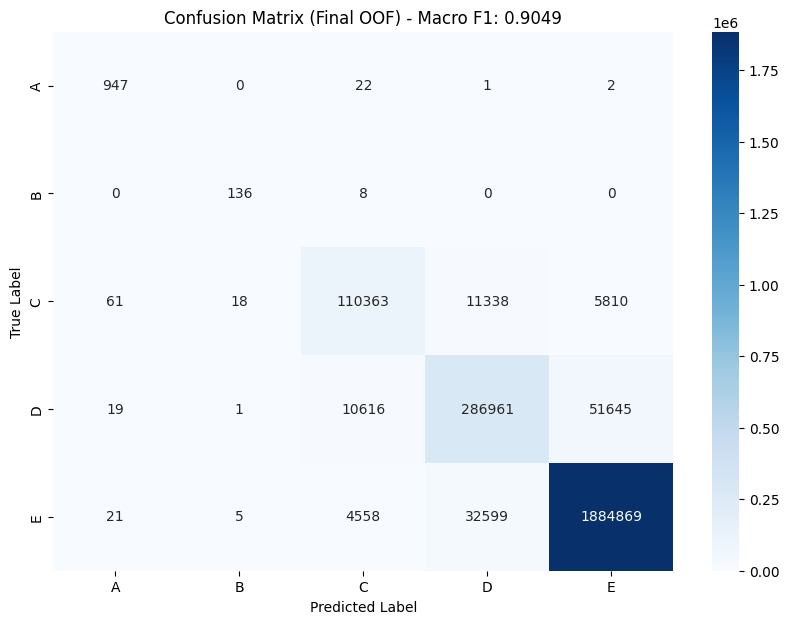

✅ Step 8 완료. (소요 시간: 717.67 분)

🔄 Step 9: 최종 제출 파일 생성 (ID별 최빈값 집계)...
  ID별 예측 레이블 집계 중 (최빈값 사용)...
  최종 예측 레이블 변환 완료.
✅ 최종 제출 파일 저장 완료: /content/drive/MyDrive/model_tuned_final_sampled/submission_tuned_mode_agg_final.csv (행 수: 100000)
           ID Segment
0  TEST_00000       D
1  TEST_00001       E
2  TEST_00002       E
3  TEST_00003       E
4  TEST_00004       E
✅ Step 9 완료. (소요 시간: 15.91 초)

🔄 Step 10: 모델 및 중요 객체 저장...
  5개 최종 Fold 모델 저장 완료.
  전처리/FE/선택 관련 객체 저장 완료.
  최종 OOF 예측 결과 저장 완료: /content/drive/MyDrive/model_tuned_final_sampled/final_oof_predictions.csv
✅ Step 10 완료. (소요 시간: 23.22 초)

🎉 모든 프로세스 완료 🎉


In [ ]:

# --- 최종 OOF 결과 평가 ---
print("\n" + "="*60)
print("📊 최종 모델 Out-of-Fold(OOF) 예측 결과 평가:")
if oof_macro_f1_scores_final:
    overall_oof_macro_f1_final = np.mean(oof_macro_f1_scores_final)
    print(f"  각 Fold 최종 OOF Macro F1: {[f'{f:.6f}' for f in oof_macro_f1_scores_final]}")
    print(f"  📈 평균 최종 OOF Macro F1 Score: {overall_oof_macro_f1_final:.6f}")
    oof_pred_labels_final = np.argmax(oof_preds_proba_final, axis=1)
    print("\n  Classification Report (Final OOF):"); print(classification_report(le_target.inverse_transform(oof_labels_final.astype(int)), le_target.inverse_transform(oof_pred_labels_final), digits=4))
    print("\n  Confusion Matrix (Final OOF):"); conf_mat_oof_final = confusion_matrix(oof_labels_final, oof_pred_labels_final); plt.figure(figsize=(10, 7)); sns.heatmap(conf_mat_oof_final, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title(f'Confusion Matrix (Final OOF) - Macro F1: {overall_oof_macro_f1_final:.4f}'); plt.savefig(os.path.join(MODEL_SAVE_PATH, 'final_oof_confusion_matrix.png')); plt.show()
else: print("  ⚠️ 최종 OOF 점수를 계산할 수 없습니다.")
end_time_step8 = time.time()
print(f"✅ Step 8 완료. (소요 시간: {(end_time_step8 - start_time_step8)/60:.2f} 분)")


# ==============================================================================
# ✅ Step 9: 최종 제출 파일 생성 (ID별 최빈값 집계)
# ------------------------------------------------------------------------------
print("\n🔄 Step 9: 최종 제출 파일 생성 (ID별 최빈값 집계)...")
start_time_step9 = time.time()
if test_preds_proba_list_final:
    avg_test_preds_proba = np.mean(test_preds_proba_list_final, axis=0)
    # print(f"  최종 테스트 예측 확률 앙상블 완료. 형태: {avg_test_preds_proba.shape}") # 로그 간소화
    pred_labels_encoded_all = np.argmax(avg_test_preds_proba, axis=1)
    if len(test_ids) == len(pred_labels_encoded_all):
        pred_df = pd.DataFrame({ID_COLUMN: test_ids.values,'predicted_label_encoded': pred_labels_encoded_all})
        print("  ID별 예측 레이블 집계 중 (최빈값 사용)...")
        id_grouped_mode = pred_df.groupby(ID_COLUMN)['predicted_label_encoded'].agg(lambda x: x.mode()[0] if not x.mode().empty else -1)
        valid_predictions = id_grouped_mode[id_grouped_mode != -1]
        final_test_pred_labels_agg = le_target.inverse_transform(valid_predictions.values)
        print("  최종 예측 레이블 변환 완료.")
        submission = pd.DataFrame({ID_COLUMN: valid_predictions.index, TARGET_COLUMN: final_test_pred_labels_agg})
        submit_filename = "re_submission_tuned_mode_agg_final.csv"
        submit_full_path = os.path.join(MODEL_SAVE_PATH, submit_filename)
        submission.to_csv(submit_full_path, index=False)
        print(f"✅ 최종 제출 파일 저장 완료: {submit_full_path} (행 수: {submission.shape[0]})")
        print(submission.head())
        # print(f"\n  제출 파일 클래스 분포:\n{submission[TARGET_COLUMN].value_counts(normalize=True)}") # 로그 간소화
    else: print(f"❌ 오류: test_ids 길이({len(test_ids)})와 예측 레이블 길이({len(pred_labels_encoded_all)}) 불일치.")
else: print("❌ 오류: 최종 테스트 예측 결과 리스트(test_preds_proba_list_final) 없음.")
end_time_step9 = time.time()
print(f"✅ Step 9 완료. (소요 시간: {end_time_step9 - start_time_step9:.2f} 초)")


# ==============================================================================
# ✅ Step 10: 모델 및 중요 객체 저장
# ------------------------------------------------------------------------------
print("\n🔄 Step 10: 모델 및 중요 객체 저장...")
start_time_step10 = time.time()
try:
    # 최종 모델 저장
    booster_paths_final = []
    for i, booster in enumerate(boosters_final):
        model_filename = f"final_xgb_booster_fold_{i+1}.json"; model_full_path = os.path.join(MODEL_SAVE_PATH, model_filename)
        booster.save_model(model_full_path); booster_paths_final.append(model_full_path)
    print(f"  {len(boosters_final)}개 최종 Fold 모델 저장 완료.")
    # 전처리/FE/선택 객체 저장
    if 'le_target' in locals(): joblib.dump(le_target, os.path.join(MODEL_SAVE_PATH, 'target_encoder_le.joblib'))
    if 'num_imputer' in locals(): joblib.dump(num_imputer, os.path.join(MODEL_SAVE_PATH, 'numerical_imputer.joblib'))
    if 'cat_imputer' in locals(): joblib.dump(cat_imputer, os.path.join(MODEL_SAVE_PATH, 'categorical_imputer.joblib'))
    if 'fit_objects_fe' in locals(): joblib.dump(fit_objects_fe, os.path.join(MODEL_SAVE_PATH, 'feature_engineering_fits.joblib'))
    if 'selected_feature_names' in locals(): joblib.dump(selected_feature_names, os.path.join(MODEL_SAVE_PATH, 'selected_feature_names.joblib'))
    print("  전처리/FE/선택 관련 객체 저장 완료.")
    # 최종 OOF 예측 결과 저장
    oof_df_final = pd.DataFrame(oof_preds_proba_final, columns=[f'pred_proba_{c}' for c in le_target.classes_])
    oof_df_final['true_label_encoded'] = oof_labels_final.astype(int); oof_df_final['true_label'] = le_target.inverse_transform(oof_labels_final.astype(int))
    oof_df_final['oof_pred_label_encoded'] = oof_pred_labels_final; oof_df_final['oof_pred_label'] = le_target.inverse_transform(oof_pred_labels_final)
    oof_save_path_final = os.path.join(MODEL_SAVE_PATH, 'final_oof_predictions.csv')
    oof_df_final.to_csv(oof_save_path_final, index=False)
    print(f"  최종 OOF 예측 결과 저장 완료: {oof_save_path_final}")
except Exception as e: print(f"❌ Step 10 저장 중 오류 발생: {e}")
end_time_step10 = time.time()
print(f"✅ Step 10 완료. (소요 시간: {end_time_step10 - start_time_step10:.2f} 초)")
print("\n🎉 모든 프로세스 완료 🎉")
